# Homework 07: Reinforcement Learning: Implementing a Deep Q-Network

Make sure to run every single cell in this notebook, or some libraries might be missing. Also, if you are using Colab, make sure to **change your Runtime (change runtime type under Runtime)** to a GPU, although it will work on a CPU.

In [3]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym gym==0.26 --force-reinstall
!pip install pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.3/710.3 kB 29.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826376 sha256=45336f8e4bdf328108fe03fcbb66a6f9e52dc9e18f6e8318fa1b56192dcc1e8a
  Stored in directory: /root/.cache/pip/wheels/8b/47/e5/04b6979e489a64e94b7af6fd69b5019c1f9addf57e206bca49
Successfully built gym
  Attempting uninstall: gym_notices
    Found existing installation: gym-notices 0.0.8
    Uninstalling gym-notices-0.0.8:
      S

In [4]:
%matplotlib inline
import os
import pdb
import sys
import copy
import json
import argparse
from datetime import datetime

import numpy as np
np.bool8 = np.bool_
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

## <span style="color:LightGreen">Implementing a DQN</span>

In this assignment you will be implementing a Deep Q-network with replay memory to play the Cartpole environment. Recall that for a DQN, we are approximating the Q-value table in Q-learning with a neural network.

The general design is a DQN neural network class that you will implemented with a DQNAgent wrapper on top. The DQNAgent controls all the weight updates and environment interactions by calling the DQN when necessary. You will also be filling in the exploration policy and you will be provided the helper class for replay memory.

## <span style="color:Orange">Problem 1</span>

In [6]:
class DQN(nn.Module):
    # YOUR CODE HERE

    # from reinforcement learning notebook:
    def __init__(self, n_observations, n_hidden, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
class QNetwork():
    # This class essentially defines the network architecture.
    # It is NOT the PyTorch Q-network model (nn.Module), but a wrapper
    # The network should take in state of the world as an input,
    # and output Q values of the actions available to the agent as the output.

    def __init__(self, args, input, output, learning_rate):
        # Define your network architecture here. It is also a good idea to define any training operations
        # and optimizers here, initialize your variables, or alternately compile your model here.
        self.weights_path = 'models/%s/%s' % (args['env'], datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
        if not os.path.exists(self.weights_path): os.makedirs(self.weights_path)
        self.input = input
        self.output = output
        self.learning_rate = learning_rate


        # Network architecture.
        self.hidden = 128
        self.model = DQN(input, self.hidden, output)

        # Loss and optimizer.
        self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        if args['model_file'] is not None:
            print('Loading pretrained model from', args['model_file'])
            self.load_model_weights(args['model_file'])

    def save_model_weights(self, step):
        # Helper function to save your model / weights.
        if not os.path.exists(self.weights_path): os.makedirs(self.weights_path)
        torch.save(self.model.state_dict(), os.path.join(self.weights_path, 'model_%d.h5' % step))

    def load_model_weights(self, weight_file):
        # Helper function to load model weights.
        self.model.load_state_dict(torch.load(weight_file))

### <span style="color:Yellow">Replay Memory Helper</span>

Replay memory or Experience replay is a simple trick used to learn the Q-value network offline. It also ensures the model can learn from past experiences without weighting heavily towards current observations.

In [8]:
class Replay_Memory():
    def __init__(self, state_dim, action_dim, memory_size=50000, burn_in=10000):
        # The memory essentially stores transitions recorder from the agent
        # taking actions in the environment.

        # Burn in episodes define the number of episodes that are written into the memory from the
        # randomly initialized agent. Memory size is the maximum size after which old elements in the memory are replaced.
        # A simple (if not the most efficient) way to implement the memory is as a list of transitions.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.states = torch.zeros((self.memory_size, state_dim))
        self.next_states = torch.zeros((self.memory_size, state_dim))
        self.actions = torch.zeros((self.memory_size, 1))
        self.rewards = torch.zeros((self.memory_size, 1))
        self.dones = torch.zeros((self.memory_size, 1))
        self.ptr = 0
        self.burned_in = False
        self.not_full_yet = True

    def append(self, states, actions, rewards, next_states, dones):
        self.states[self.ptr] = states
        self.actions[self.ptr, 0] = actions
        self.rewards[self.ptr, 0] = rewards
        self.next_states[self.ptr] = next_states
        self.dones[self.ptr, 0] = dones
        self.ptr += 1

        if self.ptr > self.burn_in:
            self.burned_in = True

        if self.ptr >= self.memory_size:
            self.ptr = 0
            self.not_full_yet = False

    def sample_batch(self, batch_size=32):
        # This function returns a batch of randomly sampled transitions - i.e. state, action, reward, next state, terminal flag tuples.
        # You will feed this to your model to train.
        if self.not_full_yet:
            idxs = torch.from_numpy(np.random.choice(self.ptr, batch_size, False))
        else:
            idxs = torch.from_numpy(np.random.choice(self.memory_size, batch_size, False))

        states = self.states[idxs]
        next_states = self.next_states[idxs]
        actions = self.actions[idxs]
        rewards = self.rewards[idxs]
        dones = self.dones[idxs]
        return states, actions, rewards, next_states, dones

## <span style="color:LightGreen">The Agent Class</span>

This section is focused on building the agent that interacts with the environment. The agent wrapper defines a policy (which you will implement), as well as all of the functionality for learning the network and using experience replay. You will implement a large chunk of this class.

## <span style="color:Orange">Problem 2</span>

In [26]:
class DQN_Agent():
    def __init__(self, args):
        # Create an instance of the network itself, as well as the memory.
        # Here is also a good place to set environmental parameters,
        # as well as training parameters - number of episodes / iterations, etc.

        # Inputs
        self.args = args
        self.environment_name = self.args['env']
        self.render = self.args['render']
        self.epsilon = args['epsilon']
        self.network_update_freq = args['network_update_freq']
        self.log_freq = args['log_freq']
        self.test_freq = args['test_freq']
        self.save_freq = args['save_freq']
        self.learning_rate = args['learning_rate']

        # variables for epsilon decay????
        self.eps_steps = 0
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 1000



        # Env related variables
        if self.environment_name == 'CartPole-v0':
            self.env = gym.make(self.environment_name, render_mode='rgb_array')
            self.discount_factor = 0.99
            self.num_episodes = 5000
        elif self.environment_name == 'MountainCar-v0':
            self.env = gym.make(self.environment_name, render_mode='rgb_array')
            self.discount_factor = 1.00
            self.num_episodes = 10000
        else:
            raise Exception("Unknown Environment")

        # Other Classes
        self.q_network = QNetwork(args, self.env.observation_space.shape[0], self.env.action_space.n, self.learning_rate)
        self.target_q_network = QNetwork(args, self.env.observation_space.shape[0], self.env.action_space.n, self.learning_rate)
        self.memory = Replay_Memory(self.env.observation_space.shape[0], self.env.action_space.n, memory_size=args['memory_size'])

        # Plotting
        self.rewards = []
        self.td_error = []
        self.batch = list(range(32))

        # Save hyperparameters
        self.logdir = 'logs/%s/%s' % (self.environment_name, datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
        if not os.path.exists(self.logdir):
            os.makedirs(self.logdir)
        with open(self.logdir + '/hyperparameters.json', 'w') as outfile:
            json.dump((self.args), outfile, indent=4)

    def epsilon_greedy_policy(self, q_values, epsilon):
        # Creating epsilon greedy probabilities to sample from.
        sample = np.random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            np.exp(-1. * self.eps_steps / self.EPS_DECAY)
        self.eps_steps += 1
        if sample > eps_threshold:
          with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            return q_values.max(1)[1].item()
            # return policy_net(q_values).max(1).indices.view(1, 1)
        else:
            return self.env.action_space.sample()



        # YOUR CODE HERE
        #raise NotImplementedError()

    def greedy_policy(self, q_values):

        # YOUR CODE HERE

        return np.argmax(q_values.detach().numpy())

    def train(self):
        # In this function, we will train our network.
        # If training without experience replay_memory, then you will interact with the environment
        # in this function, while also updating your network parameters.

        # When use replay memory, you should interact with environment here, and store these
        # transitions to memory, while also updating your model.
        self.burn_in_memory()
        for step in range(self.num_episodes):
            # Generate Episodes using Epsilon Greedy Policy and train the Q network.
            self.generate_episode(policy=self.epsilon_greedy_policy, mode='train',
                epsilon=self.epsilon, frameskip=self.args['frameskip'])

            # Test the network.
            if step % self.test_freq == 0:
                test_reward, test_error = self.test(episodes=20)
                self.rewards.append([test_reward, step])
                self.td_error.append([test_error, step])

            # Update the target network.
            if step % self.network_update_freq == 0:
                self.hard_update()

            # Logging.
            if step % self.log_freq == 0:
                print("Step: {0:05d}/{1:05d}".format(step, self.num_episodes))

            # Save the model.
            if step % self.save_freq == 0:
                self.q_network.save_model_weights(step)

            step += 1
            self.epsilon_decay()

            # Render and save the video with the model.
            if step % int(self.num_episodes / 3) == 0 and self.args['render']:
                # test_video(self, self.environment_name, step)
                self.q_network.save_model_weights(step)

    def td_estimate (self, state, action):
        # YOUR CODE HERE
        return self.q_network.model.forward(state).gather(1, action.long())


    def td_target (self, reward, next_state, done):
        # YOUR CODE HERE
        return reward + self.discount_factor * (1 - done) * torch.max(self.target_q_network.model.forward(next_state))

    def train_dqn(self):
        # Sample from the replay buffer.
        state, action, rewards, next_state, done = self.memory.sample_batch(batch_size=32)

        # Optimization step. For reference, we used F.smooth_l1_loss as our loss function.
        # YOUR CODE HERE

        self.q_network.optim.zero_grad()
        loss = torch.nn.functional.smooth_l1_loss(self.td_estimate(state, action), self.td_target(rewards, next_state, done))
        loss.backward()

        #self.env.action_space.append(action)


        self.q_network.optim.step()
        return loss

    def hard_update(self):
        self.target_q_network.model.load_state_dict(self.q_network.model.state_dict())

    def test(self, model_file=None, episodes=100):
        # Evaluate the performance of your agent over 100 episodes, by calculating cumulative rewards for the 100 episodes.
        # Here you need to interact with the environment, irrespective of whether you are using a memory.
        cum_reward = []
        td_error = []
        for count in range(episodes):
            reward, error = self.generate_episode(policy=self.epsilon_greedy_policy,
                mode='test', epsilon=0.05, frameskip=self.args['frameskip'])
            cum_reward.append(reward)
            td_error.append(error)
        cum_reward = torch.tensor(cum_reward)
        td_error = torch.tensor(td_error)
        print("\nTest Rewards: {0} | TD Error: {1:.4f}\n".format(torch.mean(cum_reward), torch.mean(td_error)))
        return torch.mean(cum_reward), torch.mean(td_error)

    def burn_in_memory(self):
        # Initialize your replay memory with a burn_in number of episodes / transitions.
        while not self.memory.burned_in:
            self.generate_episode(policy=self.epsilon_greedy_policy, mode='burn_in',
                epsilon=self.epsilon, frameskip=self.args['frameskip'])
        print("Burn Complete!")

    def generate_episode(self, policy, epsilon, mode='train', frameskip=1):
        """
        Collects one rollout from the policy in an environment.
        """
        done = False
        # Modified to handle the tuple returned by env.reset()
        state, _ = self.env.reset()  # Extract the state from the tuple
        state = torch.from_numpy(np.array(state)).type(torch.float32)  # Convert and ensure float32 type
        rewards = 0
        q_values = self.q_network.model.forward((state.reshape(1, -1)))
        td_error = []
        while not done:
            action = policy(q_values, epsilon)
            i = 0
            while (i < frameskip) and not done:
                # The step method might be returning more than 4 values
                # Use an underscore "_" to capture any extra values
                step_result = self.env.step(action)
                # Ensure we only unpack the first 4 values
                next_state, reward, done, info = step_result[:4]

                next_state = torch.from_numpy(np.array(next_state))
                rewards += reward
                i += 1
            next_q_values = self.q_network.model.forward((next_state.reshape(1, -1)))
            if mode in ['train', 'burn_in'] :
                self.memory.append(state, action, reward, next_state, done)
            else:
                td_error.append(abs(reward + self.discount_factor * (1 - done) * torch.max(next_q_values) - q_values))
            if not done:
                state = copy.deepcopy(next_state.detach())
                q_values = copy.deepcopy(next_q_values.detach())

            # Train the network.
            if mode == 'train':
                self.train_dqn()
        if td_error == []:
          return rewards, []
        return rewards, torch.mean(torch.stack(td_error))

    def plots(self):
        """
        Plots:
        1) Avg Cummulative Test Reward over 20 Plots
        2) TD Error
        """
        reward, time =  zip(*self.rewards)
        plt.figure(figsize=(8, 3))
        plt.subplot(121)
        plt.title('Cummulative Reward')
        plt.plot(time, reward)
        plt.xlabel('iterations')
        plt.ylabel('rewards')
        plt.legend()
        plt.ylim([0, None])

        loss, time =  zip(*self.td_error)
        plt.subplot(122)
        plt.title('Loss')
        plt.plot(time, loss)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

    def epsilon_decay(self, initial_eps=1.0, final_eps=0.05):
        if(self.epsilon > final_eps):
            factor = (initial_eps - final_eps) / 10000
            self.epsilon -= factor

### <span style="color:Yellow">Helpers and Hyperparameters</span>

This class contains helper functions, as well as some extra arguments that you can use to tune or play around with your DQN. There is no required parts to fill in here.

In [24]:
# Note: if you have problems creating video captures on servers without GUI,
#       you could save and relaod model to create videos on your laptop.
def test_video(agent, env_name, episodes):
    # Usage:
    #   you can pass the arguments within agent.train() as:
    #       if episode % int(self.num_episodes/3) == 0:
    #           test_video(self, self.environment_name, episode)
    save_path = "%s/video-%s" % (env_name, episodes)
    if not os.path.exists(save_path): os.makedirs(save_path)

    # To create video
    env = agent.env # gym.wrappers.Monitor(agent.env, save_path, force=True)
    reward_total = []
    # Modified to handle the tuple returned by env.reset()
    state, _ = env.reset()  # Extract the state from the tuple
    done = False
    print("Video recording the agent with epsilon {0:.4f}".format(agent.epsilon))
    while not done:
        # Convert state to a PyTorch tensor with the correct data type
        state_tensor = torch.from_numpy(state.astype(np.float32)).reshape(1, -1)
        q_values = agent.q_network.model.forward(state_tensor)
        action = agent.greedy_policy(q_values)
        i = 0
        while (i < agent.args['frameskip']) and not done:
            # The render method no longer accepts the mode argument.
            # We are already defining the render mode as 'rgb_array'
            # when initializing the environment.
            screen = env.render() # Remove the 'mode='rgb_array'' argument
            plt.imshow(screen) # screen is no longer a list
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())

            # The step method might be returning more than 4 values
            # Use an underscore "_" to capture any extra values
            step_result = env.step(action)
            # Ensure we only unpack the first 4 values
            next_state, reward, done, info = step_result[:4] # changed this line

            reward_total.append(reward)
            i += 1
        state = next_state
    print("reward_total: {}".format(torch.sum(torch.tensor(reward_total))))
    ipythondisplay.clear_output(wait=True)
    env.close()


def init_flags():

    flags = {
        "env": "CartPole-v0", # Change to "MountainCar-v0" when needed.
        "render": False,
        "train": 1,
        "frameskip" : 1,
        "network_update_freq": 10,
        "log_freq": 25,
        "test_freq": 100,
        "save_freq": 500,
        "learning_rate": 5e-4,
        "memory_size": 50000,
        "epsilon": 0.5,
        "model_file": None,
    }

    return flags

def main(render=False):
    args = init_flags()
    args["render"] = render

    # You want to create an instance of the DQN_Agent class here, and then train / test it.
    q_agent = DQN_Agent(args)

    # Render output videos using the model loaded from file.
    if args['render']: test_video(q_agent, args['env'], 1)
    else: q_agent.train()  # Train the model.

In [27]:
# For training
main()

Burn Complete!

Test Rewards: 9.399999618530273 | TD Error: 1.1581

Step: 00000/05000
Step: 00025/05000
Step: 00050/05000
Step: 00075/05000

Test Rewards: 9.899999618530273 | TD Error: 1.8082

Step: 00100/05000
Step: 00125/05000
Step: 00150/05000
Step: 00175/05000

Test Rewards: 24.350000381469727 | TD Error: 1.7559

Step: 00200/05000
Step: 00225/05000
Step: 00250/05000
Step: 00275/05000

Test Rewards: 9.699999809265137 | TD Error: 4.0891

Step: 00300/05000
Step: 00325/05000
Step: 00350/05000
Step: 00375/05000

Test Rewards: 10.399999618530273 | TD Error: 4.8466

Step: 00400/05000
Step: 00425/05000
Step: 00450/05000
Step: 00475/05000

Test Rewards: 9.600000381469727 | TD Error: 5.9357

Step: 00500/05000
Step: 00525/05000
Step: 00550/05000
Step: 00575/05000

Test Rewards: 9.800000190734863 | TD Error: 7.1211

Step: 00600/05000
Step: 00625/05000
Step: 00650/05000
Step: 00675/05000

Test Rewards: 9.25 | TD Error: 8.4412

Step: 00700/05000
Step: 00725/05000
Step: 00750/05000
Step: 00775/05

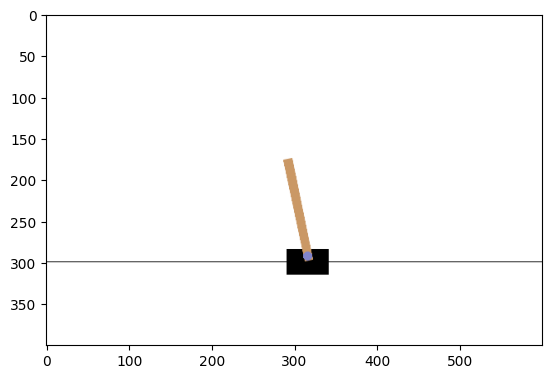

In [29]:
# For evaluating video.
main(render=True)

## <span style="color:Orange">Appendix</span>

### <span style="color:LightGreen">Resources</span>

There are many online resources for Reinforcement Learning and DQNs. Please search for them and use them as helpful background, with proper citations.


## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2024